# train Focused Scene Text and Born Digital Images

In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from dl.data.txtdetn import augmentations, datasets, target_transforms, transforms
from dl.data.txtdetn.utils import batch_ind_fn_droptexts
from dl.models.ssd.textboxespp import TextBoxesPP

from dl.loss.textboxespp import TextBoxLoss, ConfidenceLoss
from dl.optim.scheduler import IterStepLR
from dl.log import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
ignore = target_transforms.Ignore(strange=True)

augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((384, 384)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

train_dataset = datasets.Compose((datasets.ICDARFocusedSceneTextDataset, datasets.ICDARBornDigitalTextDataset, datasets.ICDAR2015TextDataset),
                                 ignore=ignore, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(384, 384, 3)).cuda()
model.load_weights('../weights/results/synthtext/pretrained-synthtext_i-60000.pth')
print(model)

TextBoxesPP(
  (codec): TextBoxCodec(
    (encoder): TextBoxEncoder()
    (decoder): TextBoxDecoder()
  )
  (defaultBox): DBoxTextBoxOriginal()
  (predictor): TextBoxPredictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

<IPython.core.display.Javascript object>


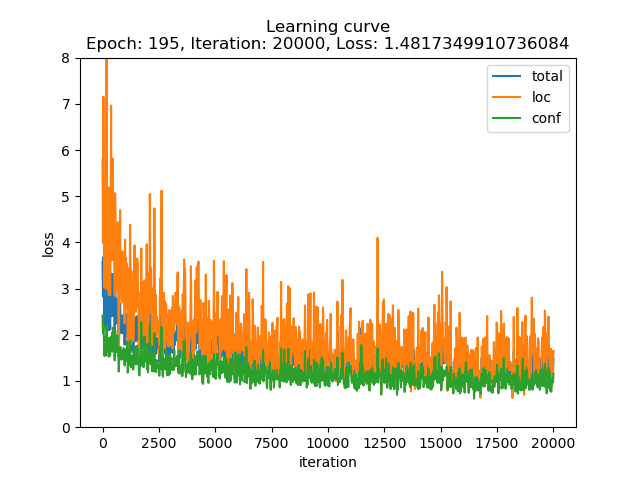

Training... Epoch: 10, Iter: 1000,	 [1168/1639	 (71%)]	Loss: 2.498540, Loc Loss: 4.061440, Conf Loss: 1.686253	Iter time: 0.1835
Saved model to ../weights/checkpoints/train-all-stage1-batch16_i-0001000_checkpoints20200630.pth

Training... Epoch: 20, Iter: 2000,	 [688/1639	 (42%)]	Loss: 1.858733, Loc Loss: 2.897054, Conf Loss: 1.279322	Iter time: 0.18150
Saved model to ../weights/checkpoints/train-all-stage1-batch16_i-0002000_checkpoints20200630.pth

Training... Epoch: 30, Iter: 3000,	 [208/1639	 (13%)]	Loss: 2.052653, Loc Loss: 2.431726, Conf Loss: 1.566308	Iter time: 0.24787
Saved model to ../weights/checkpoints/train-all-stage1-batch16_i-0003000_checkpoints20200630.pth

Training... Epoch: 39, Iter: 4000,	 [1376/1639	 (83%)]	Loss: 1.334245, Loc Loss: 1.134946, Conf Loss: 1.107256	Iter time: 0.1822
Saved model to ../weights/checkpoints/train-all-stage1-batch16_i-0004000_checkpoints20200630.pth

Training... Epoch: 49, Iter: 5000,	 [896/1639	 (54%)]	Loss: 1.564555, Loc Loss: 1.602864, Co

Traceback (most recent call last):
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


<IPython.core.display.Javascript object>


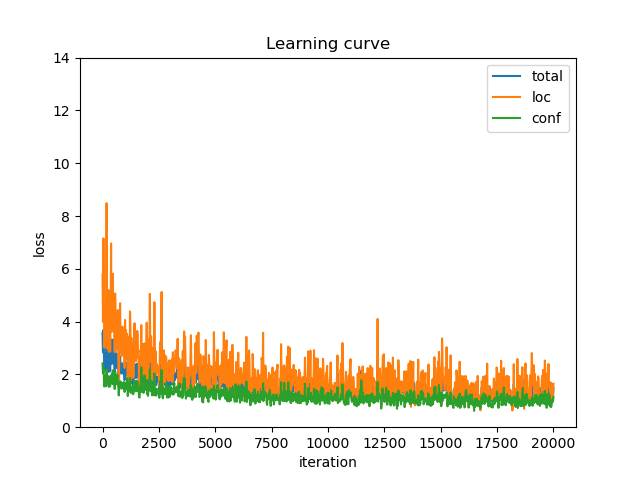

Saved graph to ../weights/results/train-all-stage1-batch16_learning-curve_i-20000.png


In [4]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

save_manager = SaveManager(modelname='train-all-stage1-batch16', interval=1000, max_checkpoints=15, plot_yrange=(0, 8), plot_interval=20)
trainer = TrainObjectDetectionJupyterLogger(LiveGraph(yrange=(0, 8)), TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=3)), model, optimizer)

trainer.train_iter(save_manager, 20000, train_loader)

In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from dl.data.txtdetn import augmentations, datasets, target_transforms, transforms
from dl.data.txtdetn.utils import batch_ind_fn_droptexts
from dl.models.ssd.textboxespp import TextBoxesPP

from dl.loss.textboxespp import TextBoxLoss, ConfidenceLoss
from dl.optim.scheduler import IterStepLR
from dl.log import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
ignore = target_transforms.Ignore(strange=True)

augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((768, 768)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

train_dataset = datasets.Compose((datasets.ICDARFocusedSceneTextDataset, datasets.ICDARBornDigitalTextDataset, datasets.ICDAR2015TextDataset),
                                 ignore=ignore, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(768, 768, 3)).cuda()
model.load_weights('../weights/results/icdar_15fstbdi/train-all-stage1-batch16_i-20000.pth')

<IPython.core.display.Javascript object>


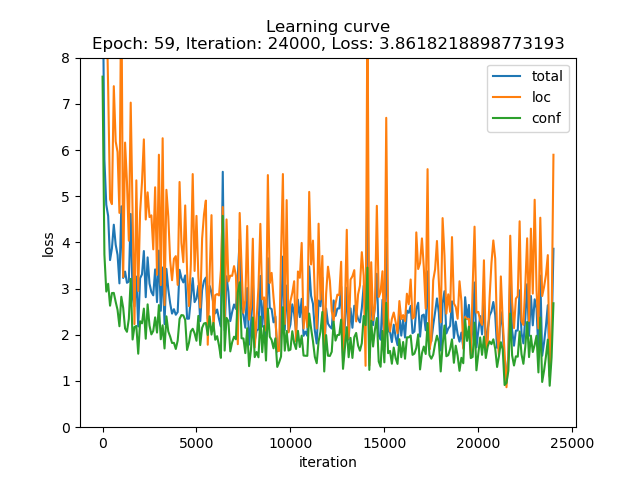

Training... Epoch: 3, Iter: 1000,	 [720/1639	 (44%)]	Loss: 4.781022, Loc Loss: 9.789557, Conf Loss: 2.823110	Iter time: 0.19358
Saved model to ../weights/checkpoints/train-all-stage2-batch8_i-0001000_checkpoints20200630.pth

Training... Epoch: 5, Iter: 2000,	 [1440/1639	 (88%)]	Loss: 3.222981, Loc Loss: 4.650895, Conf Loss: 2.292802	Iter time: 0.19952
Saved model to ../weights/checkpoints/train-all-stage2-batch8_i-0002000_checkpoints20200630.pth

Training... Epoch: 8, Iter: 3000,	 [520/1639	 (32%)]	Loss: 3.822443, Loc Loss: 5.897745, Conf Loss: 2.642895	Iter time: 0.190880
Saved model to ../weights/checkpoints/train-all-stage2-batch8_i-0003000_checkpoints20200630.pth

Training... Epoch: 10, Iter: 4000,	 [1240/1639	 (76%)]	Loss: 2.491890, Loc Loss: 3.080451, Conf Loss: 1.875800	Iter time: 0.19510
Saved model to ../weights/checkpoints/train-all-stage2-batch8_i-0004000_checkpoints20200630.pth

Training... Epoch: 13, Iter: 5000,	 [320/1639	 (20%)]	Loss: 2.786096, Loc Loss: 4.574229, Conf L

<IPython.core.display.Javascript object>


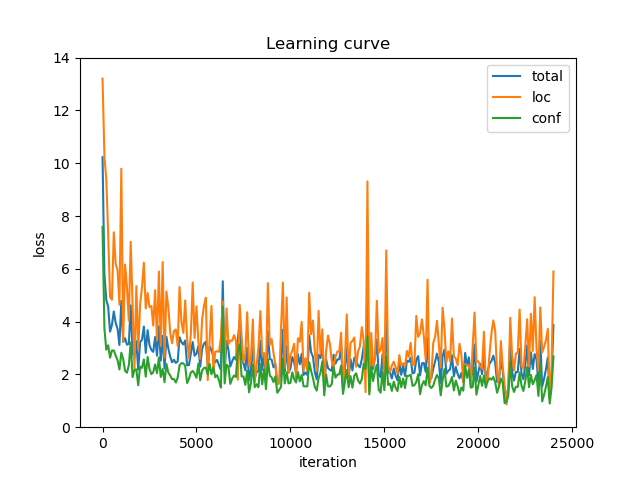

Saved graph to ../weights/results/train-all-stage2-batch8_learning-curve_i-24000.png


In [4]:
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)

save_manager = SaveManager(modelname='train-all-stage2-batch16', interval=1000, max_checkpoints=15, plot_yrange=(0, 8), plot_interval=100)
trainer = TrainObjectDetectionJupyterLogger(LiveGraph(yrange=(0, 8)), TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=6)), model, optimizer)

trainer.train_iter(save_manager, 24000, train_loader)